In [4]:
from Crypto.Util.number import bytes_to_long, long_to_bytes

# Prerequisites:

1. RSA + its prerequisites
2. Lattices and SVP/CVP problems
    * https://www.youtube.com/watch?v=2pgjdgTDSp8&list=PLKXdxQAT3tCssgaWOy5vKXAR4WTPpRVYK&index=83
3. LLL
    * https://en.wikipedia.org/wiki/Lenstra%E2%80%93Lenstra%E2%80%93Lov%C3%A1sz_lattice_basis_reduction_algorithm
4. Polynomials
5. Hastad broadcast attack
6. Patience

# Theory

**Task**:
- We need to find something. Be it a small private key $d$,  a small part of a message $m = a + x$ (a known) etc
- We are trying to form a polynomial where the solution is our target
- We are learning a method that can solve that polynomial in modulo rings, given the solution is small enough

Workflow:
- we are starting with a higher level version of the theorem
- we will see an example
- then we'll go into some details

I won't cover Lattices and LLL here

*Idea LLL*: Given a base, get a "better" base where better means shorter and more orthogonal

*Motivation*: Many cryptanalysis problems can be formulated as either
-  Find a small solution to some polynomial / system of equations subject to some constraints, or
- Find a polynomial with small coeff

**Important** LLL bounds: 
$$||v_1|| \leq ||v_2|| \leq ... \leq ||v_i|| \leq 2^{\frac {n(n-1)} {4(n+1-i)}} \cdot \det(L) ^ {\frac 1 {n+1-i}} => ||v_1|| \leq 2^{\frac {(n-1)} {4}} \cdot \det(L) ^{\frac 1 n}$$

## Setup

Explanation:  https://youtu.be/RgbrpmJ49r4?t=689

### Link between polynomials and lattices

We can write the polynomial $f(x) = f_{n-1}x^{n-1} + .. + f_1x + f_0$ as 
- $(f_{n-1}, ... f_1, f_0)$ = coefficient embedding
- $(f(x_0), f(x_1), .., f(x_{n-1}))$ = evaluation embedding

This will be the vector of some lattice

The lattice preserves the additive structure of polynomials

*Win*: Lattices introduce  **geometric proprieties** that we are going to abuse(Ex: norms) 


### Coppersmith's Theorem over univariate polynomials

Univariate polynomial = A polynomial in a single variable, e.g., $P(x)=a_2x^2+a_1x+a_0$, as opposed to a multivariate polynomial.

**Theorem**

Given a poly $f$ of degree $\delta$ and $N$, we can find in polynomial time all integer roots $r_i$ satisfying 
$$ f(r_i)\equiv 0 \ mod \ N$$
when $|r_i| < N^{1/\delta}$

**Why is this important?**
1. If there was a general solution (not limited by $N^{1/\delta}$) then we would instantly break RSA because $x^e - c \equiv 0 \ mod \ N$ => we'll would be able to find a solution
2. We can find solutions without factoring N

### Coppersmith's Algorithm

$$\text{Problem} \rightarrow f(x) \equiv 0 \ mod \ N \rightarrow g(x) = 0 \rightarrow \text{roots} |r| < R$$

1. Transform the problem into a modular polynomial equation $f(x) \equiv 0 \ mod \ N $ with some **small** root $r \ \ (f(r) \equiv 0 \ mod \ N) $
2. Construct a new polynomial over the integers $g \in \mathbb{Z}[x]$ with $g(r) = 0$
3. Find the polynomial using LLL
4. Find roots r of g efficiently

*Intuition*: Find a polynomial $g$ small enough( with small enough coefficients) that has the same root $r$ as $f$

**Constructing $g$**:  
1. Ensure $g(r) \equiv 0 \ mod \ N$ by construction
    - $f(r) \equiv 0 \ mod \ N$ and $N \equiv 0 \ mod \ N$ so
    -  $g(x) = s(x)\cdot f(x) + t(x) \cdot N$ with $ s, t \in \mathbb{Z}[x] => g(r) \equiv 0 \ mod \ N$ from construction
        - with $t(x)$ we "scale" N, with $s(x)$ we "scale" $f(x)$.
2. $g(r) < N$ to not wrap around
    - We do this by bounding with some $R$ Ex: $: g(r) = |g_nR^n  + ..g_1r + g_0| \ |g_n|R^n +  .. +|g_1|R + |g_0| < N$

From 1 and 2 => $g(r) = 0$

*Intuition*: 
- In general $g(x) = \sum_i a_i f(x), a_i \in \mathbb{Z}$ (a linear combination) of some polynomials $f_i(x)$ derived from f. The polynomials $f_i(x)$ are chosen such that they have the same roots as $f$ modulo $N$
- we are searching for $g$ that has the roots in the equality =, not the equivalence class $\equiv N$

Ex for 1.: 
Lets look at the polynomial $f(x) = x^n +  f_{n-1}x^{n-1} + ... f_1x + f_0 \equiv 0 \ mod \ N$

Consider the lattice (row vectors) spanned by:  
$w_1 = (N, 0, ..., 0) \\
w_2 = (0, RN,..., 0) \\
\vdots \\
w_{n-1} = (0, ...R^{n-1}N, 0) \\
w_n = (f_1, f_2R, ... f_{n-1}R^{n-1}, R^N)
$

All of these vectors are equivalent to $f$ (have the same root $r$ modulo N)

Then $g$ is a linear combination of $v$'s so it's a vector in the lattice => We can find it with LLL
=> We want $|v|_1 \leq \sqrt(n)|v|_2 \leq 2^{(n-1)/4} \det L^{1/\dim L} < N$

**Theorem**

It is not possible to solve for $r > N^{1/\delta}$ with any method that constructs an auxiliary polynomial $g$ that preserves all the algebraic roots

Maybe there are improvements on the bound that don't preserve all the roots

### Howgrave-Graham Theorem

Given a polynomial $f$ of degree $\delta$ and integer N, we can find in polynomial time roots $r$ modulo divisors $b$ of $N$ satisfying
$$f(r) \equiv 0 \ mod \ b$$ for $|b| > N^\beta$ when $|r| < N^{\beta^2 / \delta}$ where $0 < \beta < 1$

*Intuition*:
- Same idea as Coppersmith but we find a vector in a lattice less than $N^\beta < b$

- Instead of finding solutions mod N we find solutions mod a divisor of N

## Breaking Textbook RSA

**Task 1**: 
- Given $N$, low exponent $e$ and half of the MSB of  $m$, decrypt $m$
    - Ex: "MyPasswordIsXXXXXXXX"


Let $m = a + x$ where $a$ is known and $x$ satisfies $0 < x < R$ => $c \equiv (a+x)^e \ mod \ N => f(x) = (a+x)^e - c \ mod \ N$

**What do we want to do?**

Provided e is small enough we want to convert the problem into a SVP then use LLL to break it

1. Expand $(a + x)^e$
2. Write the lattice 
3. Get new basis LLL
4. Take the 1st vector $v_1 = ( \alpha_1, \alpha_2 .. \alpha_e)$
5. Construct $g(x) = \cfrac {\alpha_e} {R^e} x^e + \cfrac {\alpha_{e-1}} {R^{e-1}}x^{e-1} ... + \cfrac {\alpha_1} R x + \alpha_0$
6. Solve $g(x)$ for a root $R$

**Remark**: 
- $v_1$ is an approximate solution => we still need to check if it's good
- If we don't get whole numbers, we can approximate
- $e$ = the number of vectors in the basis => works well for $e < 100$

**Note**: If you got the intuition and understood until here, you can go to the Code part and look at the toy example and the first sage implementation

## Bringing up bigger lattices

- Let N = int of unknown factorization
- Let $f(x)$ = a monic poly of degree $\delta$
- Let $b$ be some divisor of $N$ with $b > N^\beta, \ 0< \beta\leq 1$

We want to find 
$f(r) = 0 \ mod \ b$ with $r \leq N^{\beta^2 / \delta}$

### Overview
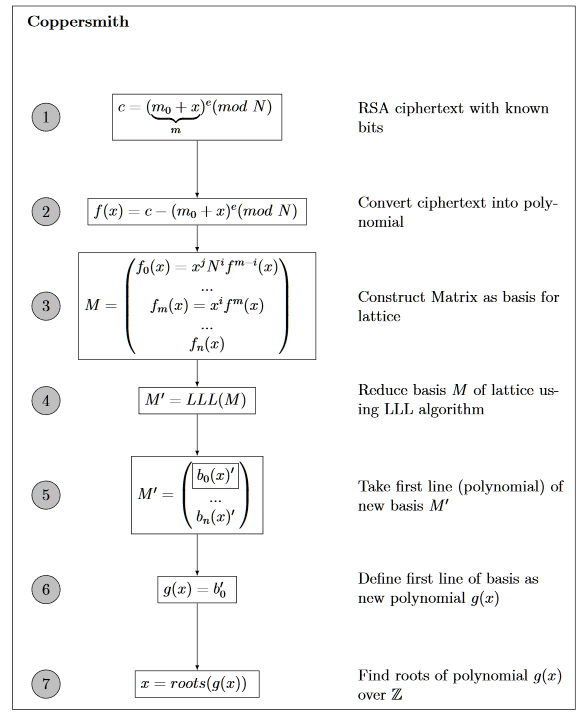

### Howgrave-Graham Lemma

Let $g(x)$ be an univariate polynomial with $n$ monomials (number of terms). Further, let $m$ be a positive integer. Suppose that
1. $ g(r) = 0 \ mod \ b^m$ where $|r| < R$ = some bound
2.  $||g(rR)|| < \cfrac {b^m} {\sqrt{(n)}}$

Then $g(r) = 0$ holds over the integers

*Inutition*:
- $m$ will be a parameter that we can tune. 
- Soon we will see how playing with $m$ will modify the lattice dimension

We can bound our determinant with LLL and the above theorem:  
$$||v_1|| = ||g(rR)|| \leq 2^{\frac {(n-1)} 4} \cdot \det(L)^{\frac 1 n} \leq \cfrac {b^m} {\sqrt{(n)}} < \cfrac {N^{\beta m}} {\sqrt{(n)}} \overset{\text{neglecting small terms}}{=>} \det(L) < 2^{-\frac {n(n-1)} 4} \cdot n^{-n/2} \cdot N^{nm} => \det(L) < N^{nm}$$ 

### Building the polynomials

Now let's construct our polynomials:

$$g(r) = \sum_{i=0}^n a_i f_i(r) = 0 \ mod b^m; \ a_i \in \mathbb{Z}$$

We pick our $f_i(x)$ from:
$$\begin{align*} 
g_{i,j}(x) &= x^j \cdot N^i \cdot f^{m-i}(x) \ & \text{for}\  i \in \{0, ..m-1\}, \ j \in \{0, ... \delta-1\} \\ 
h_i(x) &= x^i \cdot f^m(x) & \text{for}\  i \in \{0, ..t-1\}
\end{align*}$$

Where $t$ is a parameter that we need to optimize as a function of $m$

**Remarks**:
- These polynomials have the same root $r$ modulo $b^m$
- each iteration introduces a new monomial ( a new term) => we can build a triangular lattice (so that the determinant is easy to calculate)

### Building the lattice

We construct the lattice spanned by the coefficients of $g_{i,j}(xR), h_i(xR) => \dim(L) = \delta m + t$

How the lattice looks (row vectors):
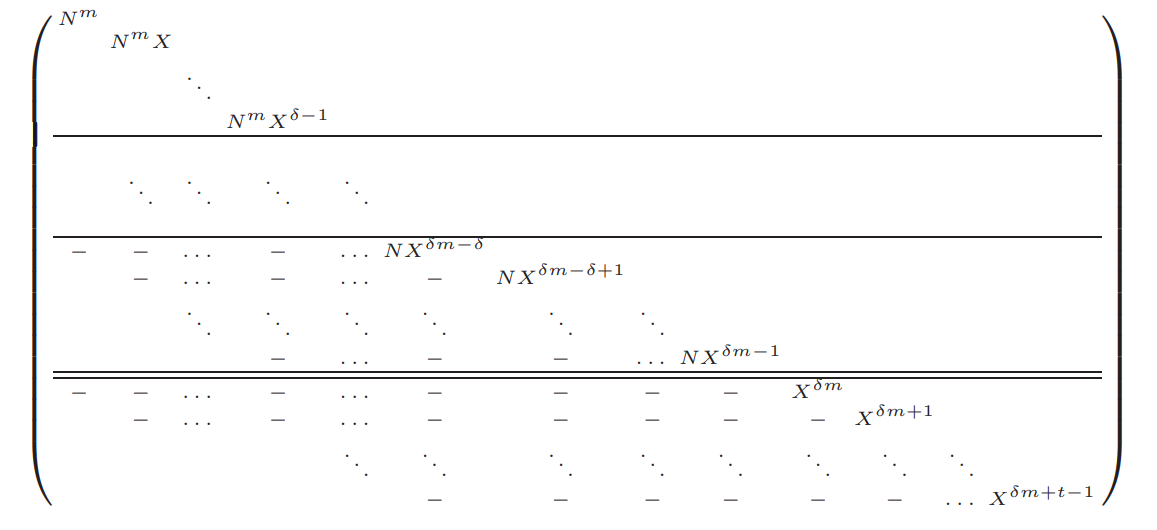

Where X = our bound R

### Discussing $m$ and $t$

**Coppersmith's theorem**

Let $f$ be a polynomial of degree $\delta$ $N$ be an integer of unknown factorization, which has a divisor $b > N^\beta; \ 0<\beta \leq 1.$ Let $0< \epsilon < \frac 1 7 \beta$
Then we can find all $r$
$$f(r) \equiv 0 \ mod \ B$$ for  $|r| < \frac 1 2 N^{\frac {\beta^2}  \delta - \epsilon}$

For details read page 9-10 of: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.86.9408&rep=rep1&type=pdf

TLDR:
Every vector that contributes to the determinant by a factor less than $N^{\beta m}$ is *helpful* => 
$$m = \bigg \lceil \cfrac {\beta^2} {\delta \epsilon} \bigg \rceil $$
$$ t = \bigg \lfloor \delta m (\cfrac 1 \beta - 1) \bigg \rfloor$$

**Remark**:
- you can also choose $m$ and $t$ yourself
- for m = 1, t = 0 we are going to get the equations we started with
- we can remove $\epsilon$ with a brute force search 

# Code

## Toy example

In [69]:
N = random_prime(2^512) * random_prime(2^512)
e = 3
message = bytes_to_long(b'thesupersecretpasswordiscoppersmith')
c = message ^3 % N

In [70]:
long_to_bytes(pow(float(c), 1/e)) == m

False

In [71]:
#the z's are the bound R
a = Integer(bytes_to_long(b'thesupersecretpasswordis' + bytes([0x00] * len('coppersmith'))))
R = Integer(bytes_to_long(bytes([0xff] * len('coppersmith'))))

In [72]:
M = matrix([
    [N, 0, 0, 0],
    [0, N*R, 0, 0],
    [0, 0, N*R^2, 0],
    [R^3, 3 * R^2 * a, 3 * R * a^2, a^3 - c]
])

In [73]:
M.parent()

Full MatrixSpace of 4 by 4 dense matrices over Integer Ring

In [74]:
B = M.LLL()

In [96]:
P.<x> = PolynomialRing(ZZ)

In [97]:
g = B[0][0] * x^3 / R^3 + B[0][1] * x^2 / R^2 + B[0][2] * x / R + B[0][3]

In [98]:
g.roots(ring = ZZ)

[(120209912955788419362550888, 1)]

In [99]:
m_decr = g.roots(ring = ZZ)[0][0]

In [100]:
long_to_bytes(m_decr)

b'coppersmith'

## Sage implementation

### High level algorithm

Sage already has the coppersmith's method implemented  
Source for code: https://github.com/ashutosh1206/Crypton/blob/master/RSA-encryption/Attack-Coppersmith/exploit.py

In [101]:
N = random_prime(2^512) * random_prime(2^512)
e = 3
m = bytes_to_long(b'thesupersecretpasswordiscoppersmith')
c = m ^3 % N
# pad with 0
a = Integer(bytes_to_long(b'thesupersecretpasswordis' + bytes([0x00] * len('coppersmith'))))
#R = Integer(bytes_to_long(bytes([0xff] * len('coppersmith'))))

In [106]:
#The polynomial describes above
P.<x> = PolynomialRing(Zmod(N))
f = (a + x)^e - c

In [107]:
def stereotyped(f, N):
    P.<x> = PolynomialRing(Zmod(N))
    f = P(f)
    beta = 1
    dd = f.degree() # Degree of the polynomial (e for the above polynomial)
    epsilon = beta/7 #
    R = ceil(N**((beta**2/dd) - epsilon)) #The bound
    r = f.small_roots(R, beta, epsilon)
    return r

In [108]:
r =stereotyped(f, N)

In [109]:
long_to_bytes(r[0])

b'coppersmith'

### Dive deeper

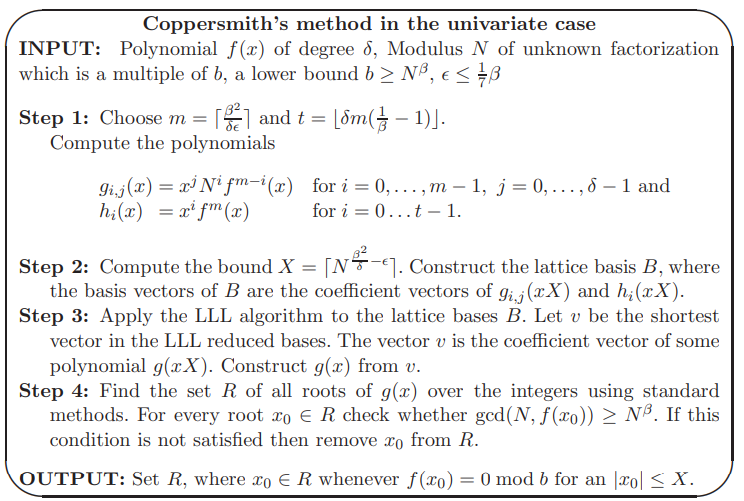

In [112]:
def coppersmith_howgrave(f, N, beta, m, t, R):
    #Check if parameters are within bounds
    assert 0 < beta <= 1, 'beta not in (0, 1]'
    assert f.is_monic(), 'f is not monic'
    
    #get delta and the matrix dimension
    delta = f.degree()
    n = delta * m + t
    
    #Building the polynomials
    fZ = f.change_ring(ZZ) #change the ring from Zmod(N) to ZZ
    x = fZ.parent().gen()  #make x a variable in ZZ
    f_list = [] 
    for ii in range(m):
        for j in range(delta):
            #We want them ordered that's we have N^(m-ii1) and fZ^ii
            f_list.append(((x*R)^j) * N^(m-ii) * fZ(x*R)^(ii)) #the g_{i,j}
    for ii in range(t):
        f_list.append((x*R)^ii * fZ(x*R)^m) #the h_i
        
    #Build the lattice
    B = matrix(ZZ, n) # n = delta * m + t
    for ii in range(n):
        for j in range(ii+1):
            B[ii, j] = f_list[ii][j]
            
    #LLL it
    B_lll = B.LLL()

    #take the shortest vector to construct our new poly g
    g = 0
    for ii in range(n):
        g += x^ii * B_lll[0, ii] / R^ii
    
    #factor the polynomial
    potential_roots = g.roots()
    print('potential roots:', potential_roots)
    
    #test roots
    roots = []
    for r in potential_roots:
        if r[0].is_integer():
            res = fZ(ZZ(r[0]))
            if gcd(N, res) >= N^beta:
                roots.append(ZZ(r[0]))
    print('roots:', roots)
    return roots

In [113]:
N = random_prime(2^512) * random_prime(2^512)
e = 3
message = bytes_to_long(b'thesupersecretpasswordiscoppersmith')
c = message ^3 % N
# pad with 0
a = Integer(bytes_to_long(b'thesupersecretpasswordis' + bytes([0x00] * len('coppersmith'))))
#R = Integer(bytes_to_long(bytes([0xff] * len('coppersmith'))))

In [114]:
#The polynomial describes above
P.<x> = PolynomialRing(Zmod(N)) #make the polynomial ring
f = (a + x)^e - c

In [115]:
# Play with these
delta = f.degree() #this is e
beta = 1                                # b = N
epsilon = beta / 7                      # <= beta / 7
m = ceil(beta**2 / (delta * epsilon))     # optimized value
t = floor(delta * m * ((1/beta) - 1))    # optimized value
R = ceil(N**((beta**2/delta) - epsilon))  # optimized value
print(m, t)

3 0


In [116]:
r = coppersmith_howgrave(f, N, beta, m, t, R)

potential roots: [(120209912955788419362550888, 2)]
roots: [120209912955788419362550888]


In [117]:
long_to_bytes(r[0])

b'coppersmith'

# Resources

- https://www.math.auckland.ac.nz/~sgal018/crypto-book/ch19.pdf
- https://www.youtube.com/watch?v=3cicTG3zeVQ&t
- https://www.youtube.com/watch?v=RgbrpmJ49r4
- https://en.wikipedia.org/wiki/Coppersmith%27s_attack
- https://en.wikipedia.org/wiki/Coppersmith_method

Papers:
- https://raw.githubusercontent.com/mimoo/RSA-and-LLL-attacks/master/survey_final.pdf
- Coppersmith paper: https://cr.yp.to/bib/2001/coppersmith.pdf
- https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.86.9408&rep=rep1&type=pdf